In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import sys

sys.path.insert(0, r"/mnt/c/Users/Trez/Desktop/tudat-bundle/tudatpy/")

# Advanced state estimation with MPC
Copyright (c) 2010-2023, Delft University of Technology. All rights reserved. This file is part of the Tudat. Redistribution and use in source and binary forms, with or without modification, are permitted exclusively under the terms of the Modified BSD license. You should have received a copy of the license with this file. If not, please visit: http://tudat.tudelft.nl/LICENSE.

## Context
This example extends the previous [Initial state estimation with Minor Planet Center Observations](https://docs.tudat.space/en/latest/_src_getting_started/_src_examples/notebooks/estimation/estimation_with_mpc.html). We introduce the inclusion of satellite data in our estimation, as well as star catalog corrections and a weighting scheme. It essential to be familiar with the previous example as many concepts will be reused here without explanation. As in the previous example we will estimate the initial state of [433 Eros](https://en.wikipedia.org/wiki/433_Eros). In addition to observation data from MPC and metadata from SBDB, we now also use ephemeris data from JPL Horizons to retrieve position data for our space telescopes and as a method of comparison. This is accomplished using Tudat's HorizonsQuery Interface.

## Import statements

In [15]:
# Tudat imports for propagation and estimation
from tudatpy.interface import spice
from tudatpy import numerical_simulation
from tudatpy.numerical_simulation import environment_setup
from tudatpy.numerical_simulation import propagation_setup
from tudatpy.numerical_simulation import estimation, estimation_setup
from tudatpy.numerical_simulation.estimation_setup import observation
from tudatpy.constants import GRAVITATIONAL_CONSTANT

# import MPC, SBDB and Horizons interface
from tudatpy.data.mpc import BatchMPC
from tudatpy.data.horizons import HorizonsQuery
from tudatpy.data.sbdb import SBDBquery


# other useful modules
import numpy as np
import datetime
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import seaborn as sns

import time
# SPICE KERNELS
spice.load_standard_kernels()

## Preparing the environment and observations

### Setting some constants
Let's setup some constants that are used throughout the tutorial. The MPC code for Eros is 433. We also set a start and end date for our observations, the number of iterations for our estimation, a timestep for our integrator and a 1 month buffer to avoid interpolation errors in our analysis.

We use a spice kernel to get a guess for our initial state and to check our estimation afterwards. The default spice kernel `codes_300ast_20100725.bsp` contains many popular asteroids, however they are not all identified by name (433 Eros is `"Eros"` but 16 Psyche is `"2000016"` etc.). To ensure this example works dynamically, for any single MPC code as input we use the SDBD to retrieve the name and SPK-ID used for the spice kernel.

For our frame origin we use the Solar System Barycentre. The data from MPC is presented in the J2000 reference frame, currently BatchMPC does not support conversion to other reference frames and as such we match it in our environment. 

Direct inputs:

In [16]:
# target_mpc_code = "433"
target_mpc_code = "183294"

observations_start = datetime.datetime(2015, 1, 1)
observations_end = datetime.datetime(2024, 1, 1)

# number of iterations for our estimation
number_of_pod_iterations = 6

# timestep of 20 hours for our estimation
timestep_global = 40 * 3600

# 1 month time buffer used to avoid interpolation errors:
time_buffer = 2 * 31 * 86400

# define the frame origin and orientation.
global_frame_origin = "SSB"
global_frame_orientation = "J2000"

Derived inputs:

In [17]:
target_sbdb = SBDBquery(target_mpc_code)

mpc_codes = [target_mpc_code]  # the BatchMPC interface requires a list.
target_spkid = target_sbdb.codes_300_spkid  # the ID used by the
target_name = target_sbdb.shortname  # the ID used by the

print(f"SPK ID for {target_name} is: {target_spkid}")

SPK ID for 183294 Langbroek is: 2183294


Combinations:

In [18]:
setup_names = ["LVL1 Accelerations", "LVL2 Accelerations", "LVL3 Accelerations"]

use_sat_data = [False, False, False]
use_catalog_cor = [False, False, False]
use_weighting = [False, False, False]
accel_levels = [1, 2, 3]

satellites_names = ["WISE"]
satellites_MPC_codes = ["C51"]
satellites_Horizons_codes = ["-163"]

In [19]:
others_to_add = ["999", "Triton", "Titania"]
others_to_add_masses = [1.3025e22, 2.1389e22, 3.4550e21]

In [20]:
file = "SiMDA_240512.csv"

target_int = int(target_mpc_code)

simbda = (
    pd.read_csv(file)
    .iloc[18:]
    .assign(NUM=lambda x: np.int32(x.NUM))
    # .assign(name=lambda x: x.NUM.astype(str) + x.DESIGNATION)
    # .query("DYN == 'NEA' | DYN == 'MBA'")
    .query("DYN == 'NEA' | (DYN == 'MBA' & MASS > 1e19)")
    # .query("(DYN == 'MBA' & MASS > 1e19)")
    .query("NUM != @target_int")

    # .query("DYN == 'NEA'")
    # .sort_values("MASS")
    # .iloc[:50]
    # .query("NUM < 5")
)

asteroids_to_add = simbda.NUM.to_list()
asteroids_to_add_masses = simbda.MASS.to_list()
# asteroids_to_use = {x for x in range(100) if x != int(target_mpc_code)}
simbda

,NUM,DESIGNATION,DYN,BD,BD.E,BD.R,RNK,DIAM,D.E,D.R,...,T.T,T.B,L.T,L.B,T.D,C_TAX,C_BD,C_BD.E,C_BD.R,C_RNK
18,1,Ceres,MBA,2.16,0.00,0,A,939.4,0.2,0,...,G,C,C,C,C,C,2.13,0.15,7,A
19,2,Pallas,MBA,2.77,0.21,8,A,520.8,12.8,2,...,B,B,-,-,B,B,2.86,0.32,11,A
20,3,Juno,MBA,3.16,0.44,14,B,251.6,9.0,4,...,S,Sk,S,Sk,Sq,Sq,3.68,0.62,17,A
21,4,Vesta,MBA,3.41,0.00,0,A,525.4,0.2,0,...,V,V,-,-,V,V,3.58,0.15,4,A
23,6,Hebe,MBA,3.60,0.85,24,C,189.5,8.3,4,...,S,S,-,-,-,S,3.81,0.5,13,A
24,7,Iris,MBA,3.18,0.80,25,C,203.8,12.4,6,...,S,S,-,-,S,S,2.14,0.81,38,C
27,10,Hygiea,MBA,2.07,0.26,12,A,427.0,15.7,4,...,C,C,-,-,C,C,2.19,0.42,19,A
32,15,Eunomia,MBA,3.48,0.45,13,B,259.0,10.7,4,...,S,S,-,-,K,K,3.54,0.2,6,B
33,16,Psyche,MBA,3.90,0.29,7,A,223.7,1.9,1,...,M,X,-,-,Xk,Xk,3.38,1.16,34,C
46,29,Amphitrite,MBA,2.47,0.49,20,A,217.2,11.2,5,...,S,S,S,L,S,S,2.38,0.51,21,C


### Retrieving the observations
We retrieve the observation data using the BatchMPC interface. By default all observation data is retrieved, even the first observations from Witt in 1898. We filter to only include data between our start and end dates.

In [29]:
batch = BatchMPC()
batch.get_observations(mpc_codes)
batch.filter(
    epoch_start=observations_start,
    epoch_end=observations_end,
)


# Retrieve the first and final observation epochs and add the buffer
epoch_start_nobuffer = batch.epoch_start
epoch_end_nobuffer = batch.epoch_end

epoch_start_buffer = epoch_start_nobuffer - time_buffer
epoch_end_buffer = epoch_end_nobuffer + time_buffer

print("Summary of space telescopes in batch:")
print(batch.observatories_table(only_space_telescopes=True))
batch.summary()
# batch.table.query("observatory == 'C51'")
# batch.table.query("observatory == 'C57'")

Summary of space telescopes in batch:
Empty DataFrame
Columns: [Code, Name, count]
Index: []

   Batch Summary:
1. Batch includes 1 minor planets:
   ['I3294']
2. Batch includes 503 observations, including 0 observations from space telescopes
3. The observations range from 2015-01-17 09:39:45.504019 to 2023-12-30 05:59:09.715219
   In seconds TDB since J2000: 474759652.6884064 to 757188018.8990325
   In Julian Days: 2457039.90261 to 2460308.749418
4. The batch contains observations from 15 observatories, including 0 space telescopes



In [22]:
# benchmark state for later comparison retrieved from SPICE
# initial_states = spice.get_body_cartesian_state_at_epoch(
#     target_spkid,
#     global_frame_origin,
#     global_frame_orientation,
#     "NONE",
#     epoch_start_buffer,
# )

temp = HorizonsQuery(
    query_id=target_mpc_code,
    location=f"@{global_frame_origin}",
    epoch_list=[epoch_start_buffer],
    extended_query=True,
)
initial_states = temp.cartesian(frame_orientation=global_frame_orientation)[0]

# Add random offset for initial guess
np.random.seed = 1

initial_position_offset = 1e6 * 1000
initial_velocity_offset = 100

initial_guess = initial_states.copy()
# initial_guess[0:3] += (2 * np.random.rand(3) - 1) * initial_position_offset
# initial_guess[3:6] += (2 * np.random.rand(3) - 1) * initial_velocity_offset

print("Error between the real initial state and our initial guess:")
print(initial_guess - initial_states)

Error between the real initial state and our initial guess:
[0. 0. 0. 0. 0. 0. 0.]


### Retrieving satellite ephemeris

In [23]:
sat_ephemeris = {}

for code, name in zip(satellites_Horizons_codes, satellites_names):
    temp = HorizonsQuery(
        query_id=code,
        location=f"@{global_frame_origin}",
        epoch_start=epoch_start_buffer,
        epoch_end=epoch_end_buffer,
        epoch_step=f"{int(timestep_global/60)}m",
        extended_query=True,
    )

    sat_ephemeris[name] = temp.create_ephemeris_tabulated(
        frame_origin=global_frame_origin,
        frame_orientation=global_frame_orientation,
    )


ast_ephemeris = {}

for code in tqdm(asteroids_to_add):
    temp = HorizonsQuery(
        query_id=f"{code};",
        location=f"@{global_frame_origin}",
        epoch_start=epoch_start_buffer - 12 * 31 * 86400,
        epoch_end=epoch_end_buffer + 12 * 31 * 86400,
        epoch_step=f"{int(timestep_global/60)}m",
        extended_query=True,
    )

    ast_ephemeris[code] = temp.create_ephemeris_tabulated(
        frame_origin=global_frame_origin,
        frame_orientation=global_frame_orientation,
    )

other_ephemeris = {}

for code in tqdm(others_to_add):
    temp = HorizonsQuery(
        query_id=f"{code}",
        location=f"@{global_frame_origin}",
        epoch_start=epoch_start_buffer - 12 * 31 * 86400,
        epoch_end=epoch_end_buffer + 12 * 31 * 86400,
        epoch_step=f"{int(timestep_global/60)}m",
        extended_query=True,
    )

    other_ephemeris[code] = temp.create_ephemeris_tabulated(
        frame_origin=global_frame_origin,
        frame_orientation=global_frame_orientation,
    )

100%|██████████| 3/3 [00:20<00:00,  6.80s/it]


### Set up the environment
We now set up the environment, including the bodies to use, the reference frame and frame origin. The epherides for all major planets as well as the Earth's Moon are retrieved using spice. 

BatchMPC will automatically generate the body object for Eros, but we still need to specify the bodies to propagate and their central bodies. We can retrieve the list from the BatchMPC object.

In [24]:
# List the bodies for our environment
bodies_to_create = [
    "Sun",
    "Mercury",
    "Venus",
    
    "Earth",
    "Moon",

    "Mars",
    "Phobos",
    "Deimos",

    "Ceres",
    "Vesta",

    "Jupiter",
    "Io",
    "Europa",
    "Ganymede",
    "Callisto",

    "Saturn",
    "Titan",
    "Rhea",
    "Iapetus",
    "Dione",
    "Tethys",
    "Enceladus",
    "Mimas",

    "Uranus",
    # "Titania",
    # "Oberon",
    # "Umbriel",
    # "Ariel",


    "Neptune",
    # "Triton"
]


# Create system of bodies
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation
)

# Add satellite ephemerides
for name in satellites_names:
    body_settings.add_empty_settings(name)
    body_settings.get(name).ephemeris_settings = sat_ephemeris[name]


# Add Asteroid ephemerides
for asteroid_MPC, asteroid_mass in zip(asteroids_to_add, asteroids_to_add_masses):
    body_settings.add_empty_settings(str(asteroid_MPC))
    body_settings.get(str(asteroid_MPC)).ephemeris_settings = ast_ephemeris[asteroid_MPC]
    body_settings.get(str(asteroid_MPC)).gravity_field_settings = (
        environment_setup.gravity_field.central(asteroid_mass * GRAVITATIONAL_CONSTANT)
    )

# Add minor planet ephemerides
for other_MPC, other_mass in zip(others_to_add, others_to_add_masses):
    body_settings.add_empty_settings(str(other_MPC))
    body_settings.get((other_MPC)).ephemeris_settings = other_ephemeris[other_MPC]
    body_settings.get((other_MPC)).gravity_field_settings = (
        environment_setup.gravity_field.central(asteroid_mass * GRAVITATIONAL_CONSTANT)
    )


bodies = environment_setup.create_system_of_bodies(body_settings)


# for asteroid_MPC, asteroid_mass in zip(asteroids_to_add, asteroids_to_add_masses):
#     bodies.get(str(asteroid_MPC)).mass = asteroid_mass

# Retrieve Eros' body name from BatchMPC and set its centre to enable its propapgation
bodies_to_propagate = batch.MPC_objects
central_bodies = [global_frame_origin]

### Creating the acceleration settings
Eros will be propagated and as such we need to define the settings of the forces acting on it. We will include point mass gravity accelerations for each of the bodies defined before, as well as Schwarzschild relativistic corrections for the Sun. With these accelerations we can generate our acceleration model for the propagation. A more realistic acceleration model will yield better results but this is outside the scope of this example. 

In [25]:
# Define accelerations
# NOTE level 1, from the basic example
accelerations_1 = {
    "Sun": [
        propagation_setup.acceleration.point_mass_gravity(),
        propagation_setup.acceleration.relativistic_correction(use_schwarzschild=True),
    ],
    "Mercury": [propagation_setup.acceleration.point_mass_gravity()],
    "Venus": [propagation_setup.acceleration.point_mass_gravity()],
    "Earth": [propagation_setup.acceleration.point_mass_gravity()],
    "Moon": [propagation_setup.acceleration.point_mass_gravity()],
    "Mars": [propagation_setup.acceleration.point_mass_gravity()],
    "Jupiter": [propagation_setup.acceleration.point_mass_gravity()],
    "Saturn": [propagation_setup.acceleration.point_mass_gravity()],
    "Uranus": [propagation_setup.acceleration.point_mass_gravity()],
    "Neptune": [propagation_setup.acceleration.point_mass_gravity()],
}


accelerations_2 = {
    "Sun": [
        propagation_setup.acceleration.point_mass_gravity(),
        propagation_setup.acceleration.relativistic_correction(use_schwarzschild=True),
    ],
    "Mercury": [propagation_setup.acceleration.point_mass_gravity()],
    "Venus": [propagation_setup.acceleration.point_mass_gravity()],

    "Earth": [propagation_setup.acceleration.point_mass_gravity()],
    "Moon": [propagation_setup.acceleration.point_mass_gravity()],

    "Mars": [propagation_setup.acceleration.point_mass_gravity()],

    "Jupiter": [propagation_setup.acceleration.point_mass_gravity()],
    "Io": [propagation_setup.acceleration.point_mass_gravity()],
    "Europa": [propagation_setup.acceleration.point_mass_gravity()],
    "Ganymede": [propagation_setup.acceleration.point_mass_gravity()],
    "Callisto": [propagation_setup.acceleration.point_mass_gravity()],

    "Saturn": [propagation_setup.acceleration.point_mass_gravity()],
    "Titan": [propagation_setup.acceleration.point_mass_gravity()],
    "Rhea": [propagation_setup.acceleration.point_mass_gravity()],
    "Iapetus": [propagation_setup.acceleration.point_mass_gravity()],
    "Dione": [propagation_setup.acceleration.point_mass_gravity()],
    
    "Uranus": [propagation_setup.acceleration.point_mass_gravity()],
    # "Titania": [propagation_setup.acceleration.point_mass_gravity()],
    # "Oberon": [propagation_setup.acceleration.point_mass_gravity()],
    # "Umbriel": [propagation_setup.acceleration.point_mass_gravity()],
    # "Ariel": [propagation_setup.acceleration.point_mass_gravity()],

    "Neptune": [propagation_setup.acceleration.point_mass_gravity()],
    # "Triton": [propagation_setup.acceleration.point_mass_gravity()],
}

accelerations_3 = {
    "Sun": [
        propagation_setup.acceleration.point_mass_gravity(),
        propagation_setup.acceleration.relativistic_correction(use_schwarzschild=True),
        # propagation_setup.acceleration.cannonball_radiation_pressure(),
    ],
    "Mercury": [propagation_setup.acceleration.point_mass_gravity()],
    "Venus": [propagation_setup.acceleration.point_mass_gravity()],
    "Earth": [
        propagation_setup.acceleration.spherical_harmonic_gravity(2, 2),
    ],
    "Moon": [propagation_setup.acceleration.point_mass_gravity()],
    "Mars": [propagation_setup.acceleration.point_mass_gravity()],
    "Phobos": [propagation_setup.acceleration.point_mass_gravity()],
    "Deimos": [propagation_setup.acceleration.point_mass_gravity()],
    # "Ceres": [propagation_setup.acceleration.point_mass_gravity()],
    # "Vesta": [propagation_setup.acceleration.point_mass_gravity()],
    "Jupiter": [propagation_setup.acceleration.point_mass_gravity()],
    "Io": [propagation_setup.acceleration.point_mass_gravity()],
    "Europa": [propagation_setup.acceleration.point_mass_gravity()],
    "Ganymede": [propagation_setup.acceleration.point_mass_gravity()],
    "Callisto": [propagation_setup.acceleration.point_mass_gravity()],
    
    "Saturn": [propagation_setup.acceleration.point_mass_gravity()],
    "Titan": [propagation_setup.acceleration.point_mass_gravity()],
    "Rhea": [propagation_setup.acceleration.point_mass_gravity()],
    "Iapetus": [propagation_setup.acceleration.point_mass_gravity()],
    "Dione": [propagation_setup.acceleration.point_mass_gravity()],
    "Tethys": [propagation_setup.acceleration.point_mass_gravity()],
    "Enceladus": [propagation_setup.acceleration.point_mass_gravity()],
    "Mimas": [propagation_setup.acceleration.point_mass_gravity()],

    "Uranus": [propagation_setup.acceleration.point_mass_gravity()],
    "Neptune": [propagation_setup.acceleration.point_mass_gravity()],
}


asteroid_accelerations = {str(num):[propagation_setup.acceleration.point_mass_gravity()] for num in asteroids_to_add}
other_accelerations = {str(num):[propagation_setup.acceleration.point_mass_gravity()] for num in others_to_add}

accelerations_3 = (accelerations_3 | asteroid_accelerations) | other_accelerations
acceleration_sets = {1: accelerations_1, 2: accelerations_2, 3:accelerations_3}

for key, val in accelerations_3.items():
    print(f"{key} | {val}")

Sun | [<tudatpy.kernel.numerical_simulation.propagation_setup.acceleration.AccelerationSettings object at 0x7fe25443dcf0>, <tudatpy.kernel.numerical_simulation.propagation_setup.acceleration.RelativisticAccelerationCorrectionSettings object at 0x7fe25443e730>]
Mercury | [<tudatpy.kernel.numerical_simulation.propagation_setup.acceleration.AccelerationSettings object at 0x7fe25443ebf0>]
Venus | [<tudatpy.kernel.numerical_simulation.propagation_setup.acceleration.AccelerationSettings object at 0x7fe25443ecf0>]
Earth | [<tudatpy.kernel.numerical_simulation.propagation_setup.acceleration.SphericalHarmonicAccelerationSettings object at 0x7fe25443cf70>]
Moon | [<tudatpy.kernel.numerical_simulation.propagation_setup.acceleration.AccelerationSettings object at 0x7fe25443daf0>]
Mars | [<tudatpy.kernel.numerical_simulation.propagation_setup.acceleration.AccelerationSettings object at 0x7fe25443d8b0>]
Phobos | [<tudatpy.kernel.numerical_simulation.propagation_setup.acceleration.AccelerationSetting

### Finalising the propagation setup
For the integrator we use the fixed timestep RKF-7(8) setting our initial time to the time of the batch's final observation - buffer. We then set the termination to stop at the time of the batch's oldest observation plus buffer. These two settings are then the final pieces to create our propagation settings. 

In [26]:
# Create numerical integrator settings
integrator_settings = propagation_setup.integrator.runge_kutta_variable_step_size(
    epoch_start_buffer,
    timestep_global,
    propagation_setup.integrator.rkf_78,
    timestep_global,
    timestep_global,
    1.0,
    1.0,
)

# Terminate at the time of oldest observation
termination_condition = propagation_setup.propagator.time_termination(epoch_end_buffer)

In [27]:
def perform_estimation(
    bodies,
    acceleration_level:int,
    use_satellite_data: bool,
    apply_star_catalog_debias: bool,
    apply_weighting_scheme: bool,
):
    if use_satellite_data:
        included_satellites = {
            mpc: name for mpc, name in zip(satellites_MPC_codes, satellites_names)
        }
    else:
        included_satellites = None

    batch_temp = batch.copy()

    observation_collection = batch_temp.to_tudat(
        bodies=bodies,
        included_satellites=included_satellites,
        apply_star_catalog_debias=apply_star_catalog_debias,
        apply_weights_VFCC17=apply_weighting_scheme,
    )

    # if acceleration_level == 3:
    #     bodies.get_body("433").mass = 6.687e15
    #     radiation_pressure_settings = environment_setup.radiation_pressure.cannonball(
    #         "Sun", np.pi * 8000**2, 1.2, []
    #     )

    #     # add radiation pressure interface to "Spacecraft" body
    #     environment_setup.add_radiation_pressure_interface(
    #         bodies, "433", radiation_pressure_settings
    #     )

    # Set up the accelerations settings for each body, in this case only Eros
    acceleration_settings = {}
    for body in bodies_to_propagate:
        acceleration_settings[str(body)] = acceleration_sets[acceleration_level]

    # create the acceleration models.
    acceleration_models = propagation_setup.create_acceleration_models(
        bodies, acceleration_settings, bodies_to_propagate, central_bodies
    )

    # set create angular_position settings for each link in the list.
    observation_settings_list = list()
    link_list = list(
        observation_collection.get_link_definitions_for_observables(
            observable_type=observation.angular_position_type
        )
    )
    for link in link_list:
        # add optional bias settings here
        observation_settings_list.append(
            observation.angular_position(link, bias_settings=None)
        )

    # Create propagation settings
    propagator_settings = propagation_setup.propagator.translational(
        central_bodies=central_bodies,
        acceleration_models=acceleration_models,
        bodies_to_integrate=bodies_to_propagate,
        initial_states=initial_guess,
        initial_time=epoch_start_buffer,
        integrator_settings=integrator_settings,
        termination_settings=termination_condition,
    )

    # Setup parameters settings to propagate the state transition matrix
    parameter_settings = estimation_setup.parameter.initial_states(
        propagator_settings, bodies
    )

    # Create the parameters that will be estimated
    parameters_to_estimate = estimation_setup.create_parameter_set(
        parameter_settings, bodies, propagator_settings
    )

    # Set up the estimator
    estimator = numerical_simulation.Estimator(
        bodies=bodies,
        estimated_parameters=parameters_to_estimate,
        observation_settings=observation_settings_list,
        propagator_settings=propagator_settings,
        integrate_on_creation=True,
    )

    # provide the observation collection as input, and limit number of iterations for estimation.
    pod_input = estimation.EstimationInput(
        observations_and_times=observation_collection,
        convergence_checker=estimation.estimation_convergence_checker(
            maximum_iterations=number_of_pod_iterations,
        ),
    )

    if apply_weighting_scheme:
        pod_input.set_weights_from_observation_collection()

    # Set methodological options
    pod_input.define_estimation_settings(reintegrate_variational_equations=True)

    pod_output = estimator.perform_estimation(pod_input)

    return pod_output, batch_temp, observation_collection, estimator

In [28]:
p_out_set = []
batch_set = []
obs_col_set = []
est_set = []
state_estimates_set = []

times_get_eph = np.linspace(epoch_start_nobuffer, epoch_end_nobuffer, 500)

for idx, setup_name in enumerate(setup_names):
    print(f"\n### Running setup #{idx+1} | {setup_name} ###")

    pod_output, batch, observation_collection, estimator = (
        perform_estimation(
            bodies,
            acceleration_level=accel_levels[idx],
            use_satellite_data=use_sat_data[idx],
            apply_star_catalog_debias=use_catalog_cor[idx],
            apply_weighting_scheme=use_weighting[idx],
            # times_get_eph=times_get_eph,
        )
    )
    state_estimates = []
    for timee in times_get_eph:
        state_est = bodies.get(str(target_mpc_code)).ephemeris.cartesian_state(timee)
        state_estimates.append(state_est)

    # time.sleep(70)

    p_out_set.append(pod_output)
    batch_set.append(batch)
    obs_col_set.append(observation_collection)
    est_set.append(estimator)
    state_estimates_set.append(state_estimates)


### Running setup #1 | LVL1 Accelerations ###


RuntimeError: Error when compiling full weights vector from single observation set, sizes are inconsistent

## Visualising the results

#### Change in residuals per iteration
We want to visualise the residuals, splitting them between Right Ascension and Declination. Internally, `concatentated_observations` orders the observations alternating RA, DEC, RA, DEC,... This allows us to map the colors accordingly by taking every other item in the `residual_history`/`concatentated_observations`, i.e. by slicing [::2].

In [ ]:
def plot_residuals(setup_names:list, p_out_set:list, obs_col_set:list):
    number_of_columns = len(p_out_set)

    iters_to_use = list(range(0, number_of_pod_iterations))
    number_of_rows = len(iters_to_use)

    fig, axs = plt.subplots(
        number_of_rows,
        number_of_columns,
        figsize=(number_of_columns * 4.0, 3.5 * number_of_rows),
        sharex=True,
        sharey=False,
    )

    if len(axs.shape) == 1:
        axs = np.reshape(axs, (len(axs), 1))

    for setup_idx, (p_out, obs_col, setup_name) in enumerate(
        zip(p_out_set, obs_col_set, setup_names)
    ):
        residual_history = p_out.residual_history

        # We cheat a little to get an approximate year out of our times (which are in seconds since J2000)
        residual_times = np.array(obs_col.concatenated_times) / (86400 * 365.25) + 2000

        # plot the residuals, split between RA and DEC types
        for i in range(number_of_rows):
            axs[i, setup_idx].grid()

            axs[i, setup_idx].scatter(
                residual_times[::2],
                residual_history[
                    ::2,
                    idx,
                ],
                marker="+",
                s=60,
                label="Right Ascension",
            )
            axs[i, setup_idx].scatter(
                residual_times[1::2],
                residual_history[
                    1::2,
                    idx,
                ],
                marker="+",
                s=60,
                label="Declination",
            )

            if i == 0:
                axs[i, setup_idx].set_title(
                    f"Setup: {setup_name}\n" + "Iteration " + str(i + 1)
                )
            else:
                axs[i, setup_idx].set_title("Iteration " + str(i + 1))

            if setup_idx == 0:
                axs[i, setup_idx].set_ylabel("Observation Residual [rad]")

    plt.tight_layout()

    # add the year label for the x-axis
    for col in range(number_of_columns):
        axs[int(number_of_rows - 1), col].set_xlabel("Year")

    axs[0, 0].legend()

    plt.show()

In [ ]:
def plot_cartesian(state_estimates_set, setup_names, obs_col_set):
    # ##########################################################################
    # lets get ranges for all gaps larger than 6 months:
    residual_times = (
        np.array(obs_col_set[0].concatenated_times) / (86400 * 365.25) + 2000
    )

    gap_in_months = 6

    gaps = np.abs(np.diff(sorted(residual_times)))
    num_gaps = (
        gaps > (gap_in_months / 12)
    ).sum()  # counts the number of gaps larger than 0.5 years
    indices_of_largest_gaps = np.argsort(gaps)[-num_gaps:]

    # (start, end) for each of the gaps
    gap_ranges = [
        (sorted(residual_times)[idx - 1], sorted(residual_times)[idx + 1])
        for idx in indices_of_largest_gaps
    ]

    # ##########################################################################

    fig, axs = plt.subplots(3, 2, figsize=(12, 15))

    # retrieve the states for a list of times.
    spice_states = []
    # times = np.linspace(epoch_start_nobuffer, epoch_end_nobuffer, 500)
    times_plot = times_get_eph / (86400 * 365.25) + 2000  # approximate
    for timee in times_get_eph:
        # from spice
        state_spice = spice.get_body_cartesian_state_at_epoch(
            target_spkid, central_bodies[0], global_frame_orientation, "NONE", timee
        )
        spice_states.append(state_spice)

    horizons_query = HorizonsQuery(
        query_id=f"{target_mpc_code};",
        location=f"500@{global_frame_origin}",
        epoch_list=list(times_get_eph),
        extended_query=True,
    )

    horizons_states = horizons_query.cartesian(frame_orientation=global_frame_orientation)[:, 1:]

    for state_estt, setup_name in zip(state_estimates_set, setup_names):
        # Error in kilometers
        error_spice = (np.array(spice_states) - np.array(state_estt)) / 1000
        error_jpl = (horizons_states - np.array(state_estt)) / 1000

        # plot
        axs[0, 0].plot(times_plot, error_spice[:, 0], label=setup_name)
        axs[1, 0].plot(times_plot, error_spice[:, 1], label=setup_name)
        axs[2, 0].plot(times_plot, error_spice[:, 2], label=setup_name)

        axs[0, 1].plot(times_plot, error_jpl[:, 0], label=setup_name)
        axs[1, 1].plot(times_plot, error_jpl[:, 1], label=setup_name)
        axs[2, 1].plot(times_plot, error_jpl[:, 2], label=setup_name)

    for idx, ax in enumerate(axs.flatten()):
        # show areas where there are no observations:
        for i, gap in enumerate(gap_ranges):
            ax.axvspan(
                xmin=gap[0],
                xmax=gap[1],
                color="red" if idx % 2 == 0 else "blue",
                alpha=0.1,
                label="Large gap in observations" if i == 0 else None,
            )
        ax.grid()

    axs[0, 0].legend(ncol=1)
    axs[0, 0].set_ylabel("X Carthesian Error [km]")
    axs[1, 0].set_ylabel("Y Carthesian Error [km]")
    axs[2, 0].set_ylabel("Z Carthesian Error [km]")
    axs[2, 0].set_xlabel("Year")

    axs[0, 0].set_title(f"Error vs SPICE over time for {target_name}")
    axs[0, 1].set_title(f"Error vs JPL HORIZONS over time for {target_name}")
    fig.set_tight_layout(True)

    plt.show()

In [ ]:
def plot_cartesian_single(state_estimate, setup_name, obs_col):
    # ##########################################################################
    # lets get ranges for all gaps larger than 6 months:
    residual_times = np.array(obs_col.concatenated_times) / (86400 * 365.25) + 2000

    gap_in_months = 6

    gaps = np.abs(np.diff(sorted(residual_times)))
    num_gaps = (
        gaps > (gap_in_months / 12)
    ).sum()  # counts the number of gaps larger than 0.5 years
    indices_of_largest_gaps = np.argsort(gaps)[-num_gaps:]

    # (start, end) for each of the gaps
    gap_ranges = [
        (sorted(residual_times)[idx - 1], sorted(residual_times)[idx + 1])
        for idx in indices_of_largest_gaps
    ]

    # ##########################################################################

    fig, axs = plt.subplots(2, 1, figsize=(12, 9))

    # retrieve the states for a list of times.
    spice_states = []
    # times = np.linspace(epoch_start_nobuffer, epoch_end_nobuffer, 500)
    times_plot = times_get_eph / (86400 * 365.25) + 2000  # approximate
    for timee in times_get_eph:
        # from spice
        state_spice = spice.get_body_cartesian_state_at_epoch(
            target_spkid, central_bodies[0], global_frame_orientation, "NONE", timee
        )
        spice_states.append(state_spice)

    horizons_query = HorizonsQuery(
        query_id=f"{target_mpc_code};",
        location=f"500@{global_frame_origin}",
        epoch_list=list(times_get_eph),
        extended_query=True,
    )

    horizons_states = horizons_query.cartesian(
        frame_orientation=global_frame_orientation
    )[:, 1:]

    error_spice = (np.array(spice_states) - np.array(state_estimate)) / 1000
    error_jpl = (horizons_states - np.array(state_estimate)) / 1000

    # plot
    axs[0].plot(times_plot, error_spice[:, 0], label="X")
    axs[0].plot(times_plot, error_spice[:, 1], label="Y")
    axs[0].plot(times_plot, error_spice[:, 2], label="Z")

    axs[1].plot(times_plot, error_jpl[:, 0])
    axs[1].plot(times_plot, error_jpl[:, 1])
    axs[1].plot(times_plot, error_jpl[:, 2])

    for idx, ax in enumerate(axs.flatten()):
        # show areas where there are no observations:
        for i, gap in enumerate(gap_ranges):
            ax.axvspan(
                xmin=gap[0],
                xmax=gap[1],
                color="red" if idx % 2 == 0 else "blue",
                alpha=0.1,
                label="Large gap in observations" if i == 0 else None,
            )
        ax.grid()

    axs[0].legend(ncol=1)
    axs[0].set_ylabel("Carthesian Error [km]")
    axs[1].set_ylabel("Carthesian Error [km]")
    axs[0].set_xlabel("Year")

    axs[0].set_title(f"Error vs SPICE over time for {target_name}")
    axs[1].set_title(f"Error vs JPL HORIZONS over time for {target_name}")
    fig.suptitle(f"Setup: {setup_name}")
    fig.set_tight_layout(True)

    plt.show()

# Actual Plots

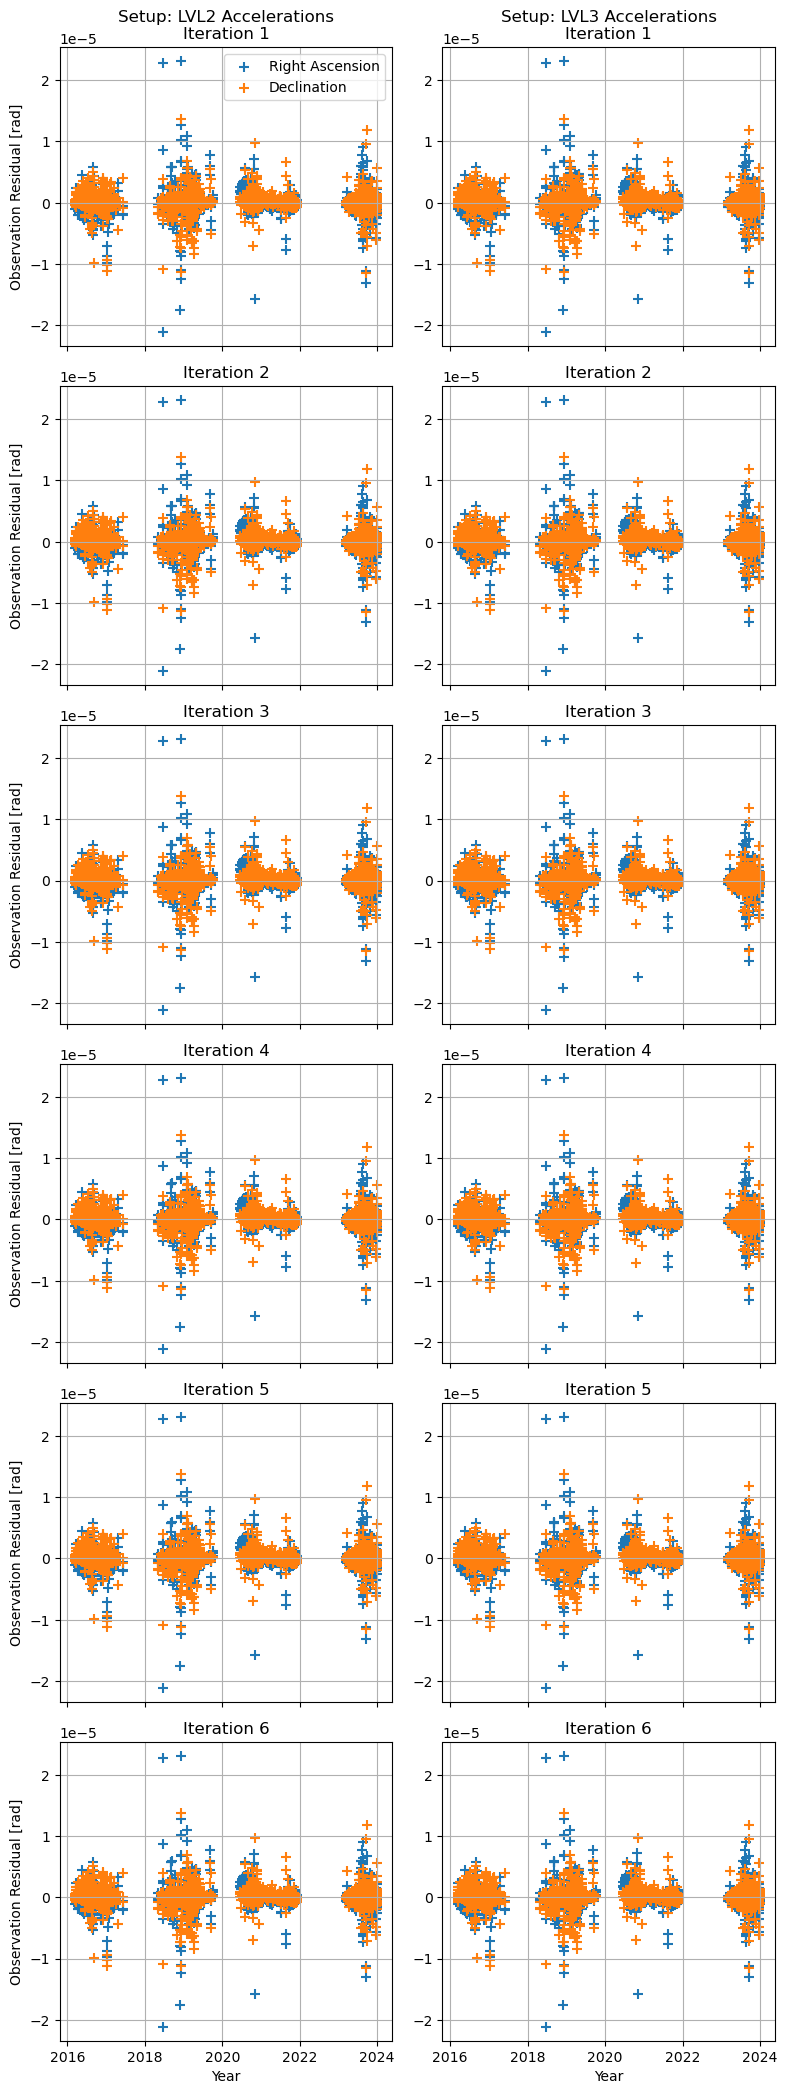

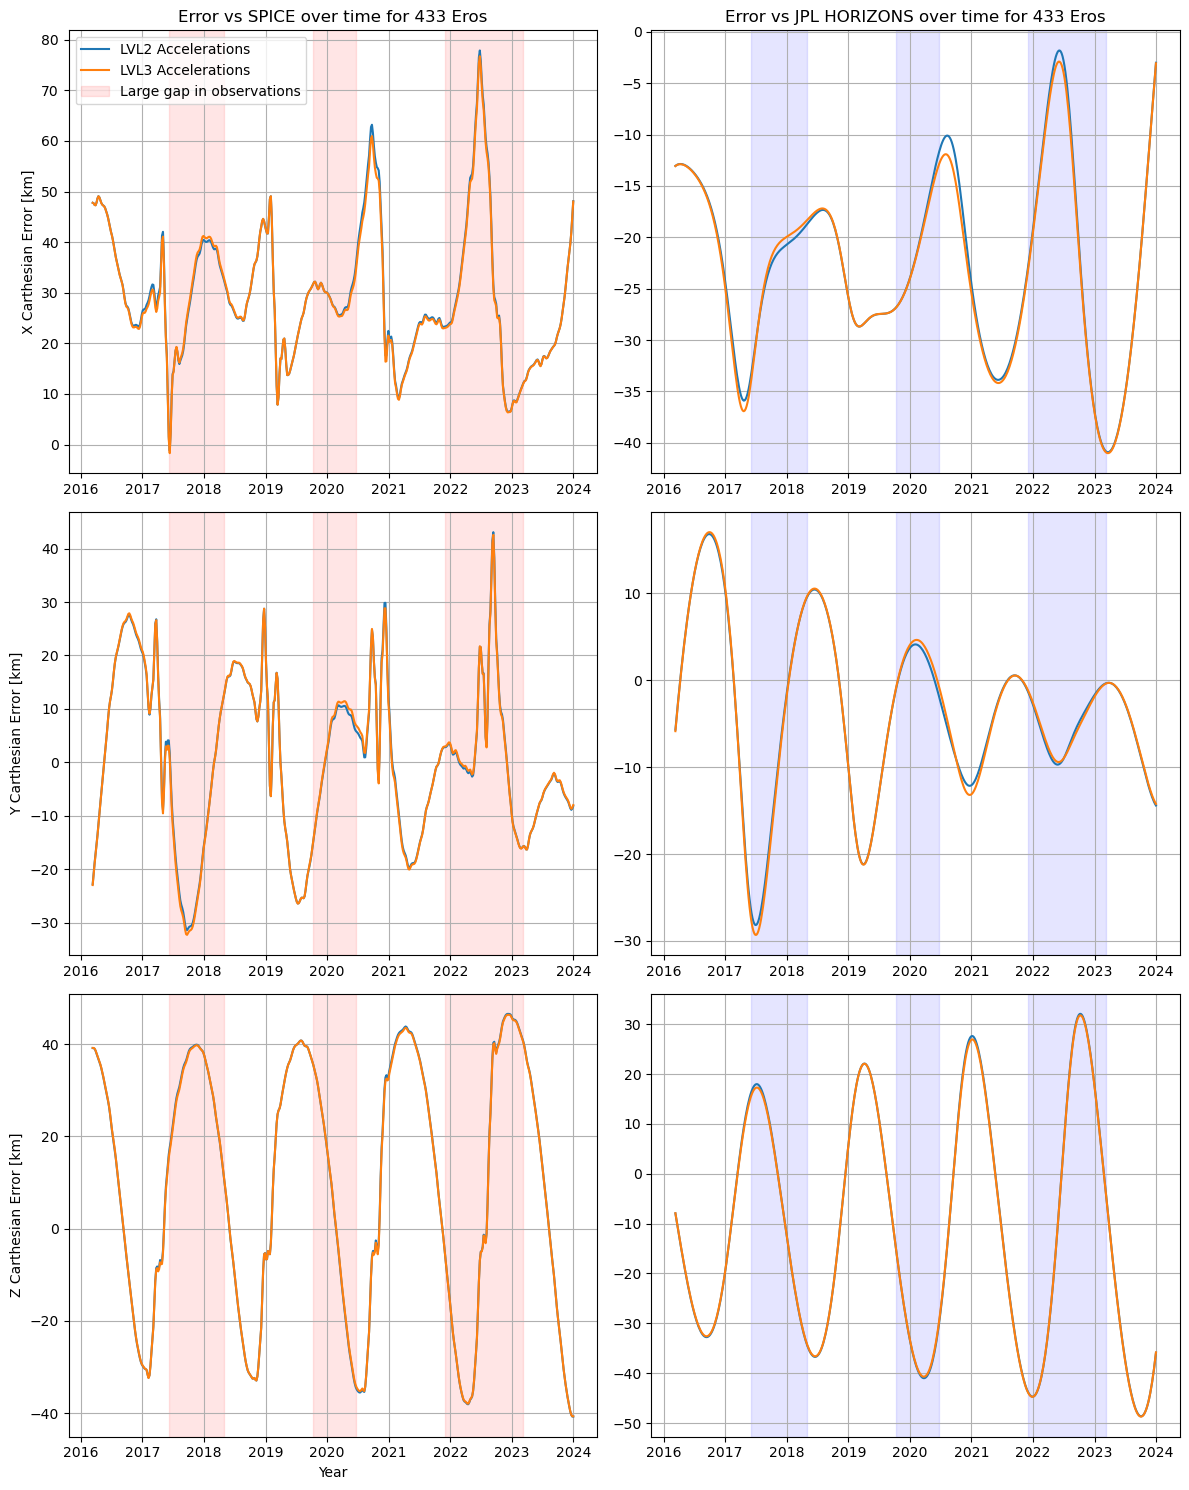

In [ ]:
plot_residuals(setup_names[1:], p_out_set[1:], obs_col_set[1:])
plot_cartesian(state_estimates_set[1:], setup_names[1:], obs_col_set[1:])

## PART 2

In [ ]:
setup_names2 = ["LVL2 + star catalog corrections", "LVL2 + weighting", "LVL2 + Satellite Data + weights"]

use_catalog_cor = [True, False, False]
use_weighting = [False, True, True]
use_sat_data = [False, False, True]
accel_levels = [2, 2, 2]

satellites_names = ["WISE"]
satellites_MPC_codes = ["C51"]
satellites_Horizons_codes = ["-163"]

In [ ]:
p_out_set2 = []
batch_set2 = []
obs_col_set2 = []
est_set2 = []
state_estimates_set2 = []

times_get_eph = np.linspace(epoch_start_nobuffer, epoch_end_nobuffer, 500)

for idx, setup_name in enumerate(setup_names):
    print(f"\n### Running setup #{idx+1} | {setup_name} ###")

    pod_output, batch, observation_collection, estimator = perform_estimation(
        bodies,
        acceleration_level=accel_levels[idx],
        use_satellite_data=use_sat_data[idx],
        apply_star_catalog_debias=use_catalog_cor[idx],
        apply_weighting_scheme=use_weighting[idx],
        # times_get_eph=times_get_eph,
    )
    state_estimates = []
    for timee in times_get_eph:
        state_est = bodies.get(str(target_mpc_code)).ephemeris.cartesian_state(timee)
        state_estimates.append(state_est)

    p_out_set2.append(pod_output)
    batch_set2.append(batch)
    obs_col_set2.append(observation_collection)
    est_set2.append(estimator)
    state_estimates_set2.append(state_estimates)


### Running setup #1 | LVL1 Accelerations ###
[<tudatpy.kernel.numerical_simulation.estimation.SingleObservationSet object at 0x7fb874068c30>, <tudatpy.kernel.numerical_simulation.estimation.SingleObservationSet object at 0x7fb87400fc70>, <tudatpy.kernel.numerical_simulation.estimation.SingleObservationSet object at 0x7fb874556030>, <tudatpy.kernel.numerical_simulation.estimation.SingleObservationSet object at 0x7fb873761d70>, <tudatpy.kernel.numerical_simulation.estimation.SingleObservationSet object at 0x7fb873323830>, <tudatpy.kernel.numerical_simulation.estimation.SingleObservationSet object at 0x7fb873b7b870>, <tudatpy.kernel.numerical_simulation.estimation.SingleObservationSet object at 0x7fb873bffeb0>, <tudatpy.kernel.numerical_simulation.estimation.SingleObservationSet object at 0x7fb87077a370>, <tudatpy.kernel.numerical_simulation.estimation.SingleObservationSet object at 0x7fb87326aeb0>, <tudatpy.kernel.numerical_simulation.estimation.SingleObservationSet object at 0x7fb8740

In [ ]:
setup_names2.append(setup_names[1])
p_out_set2.append(p_out_set[1])
obs_col_set2.append(obs_col_set[1])
state_estimates_set2.append(state_estimates_set[1])

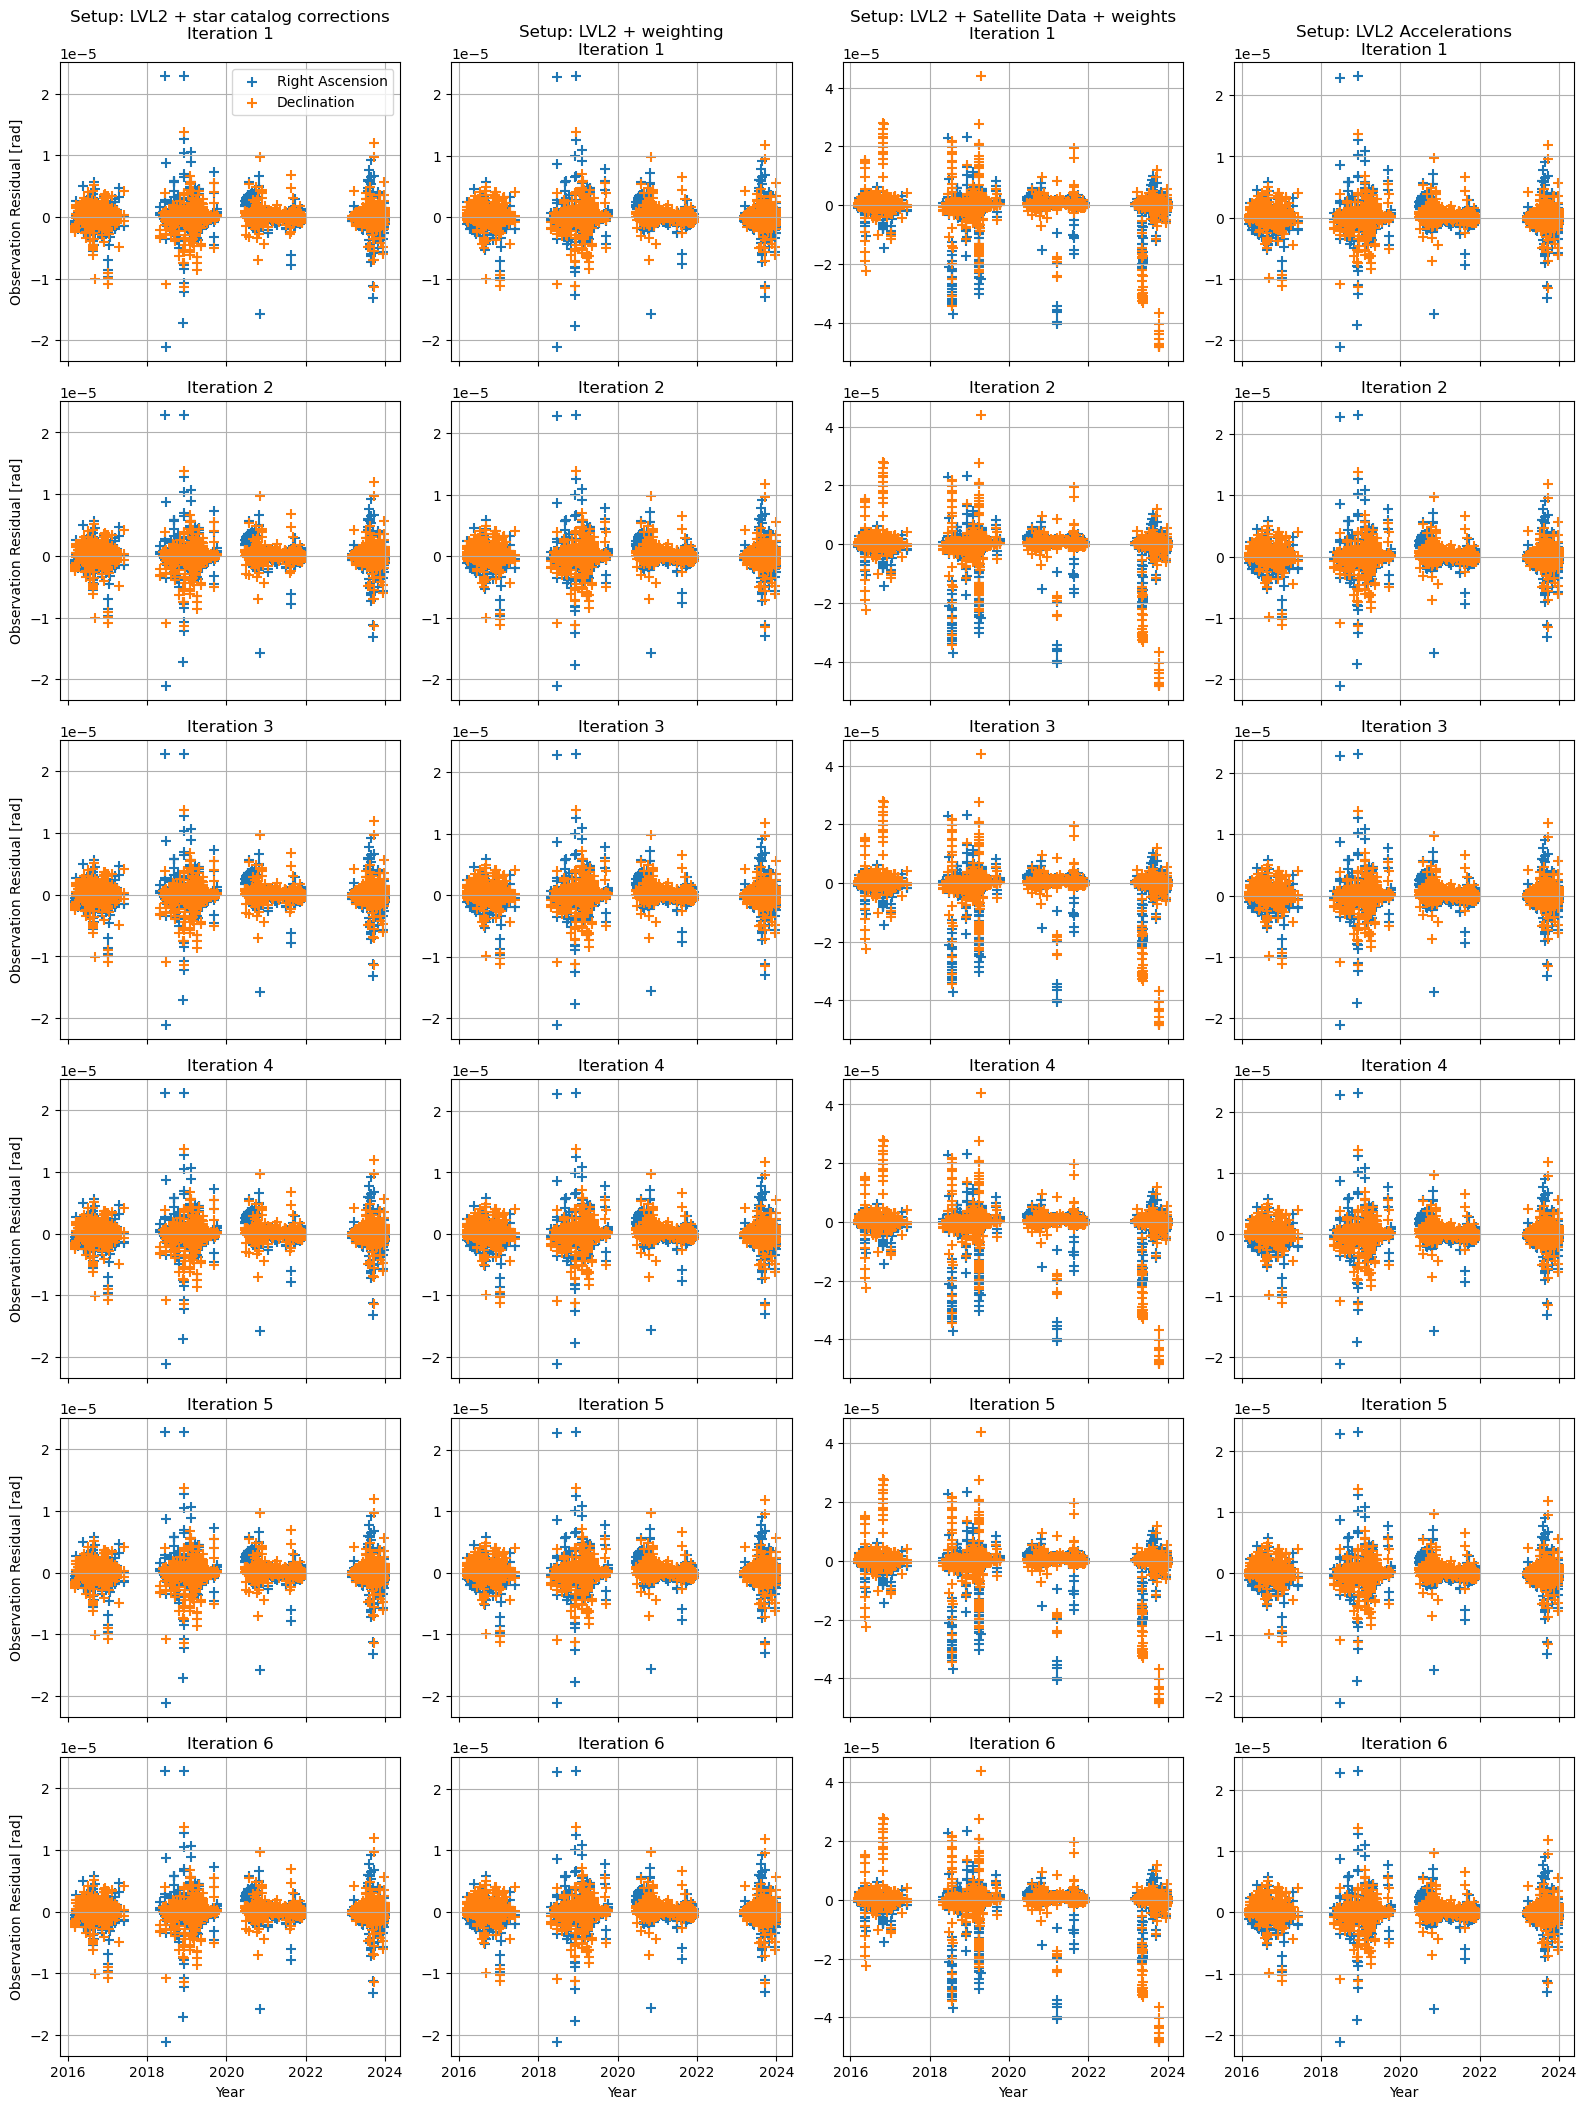

In [ ]:
plot_residuals(setup_names2, p_out_set2, obs_col_set2)


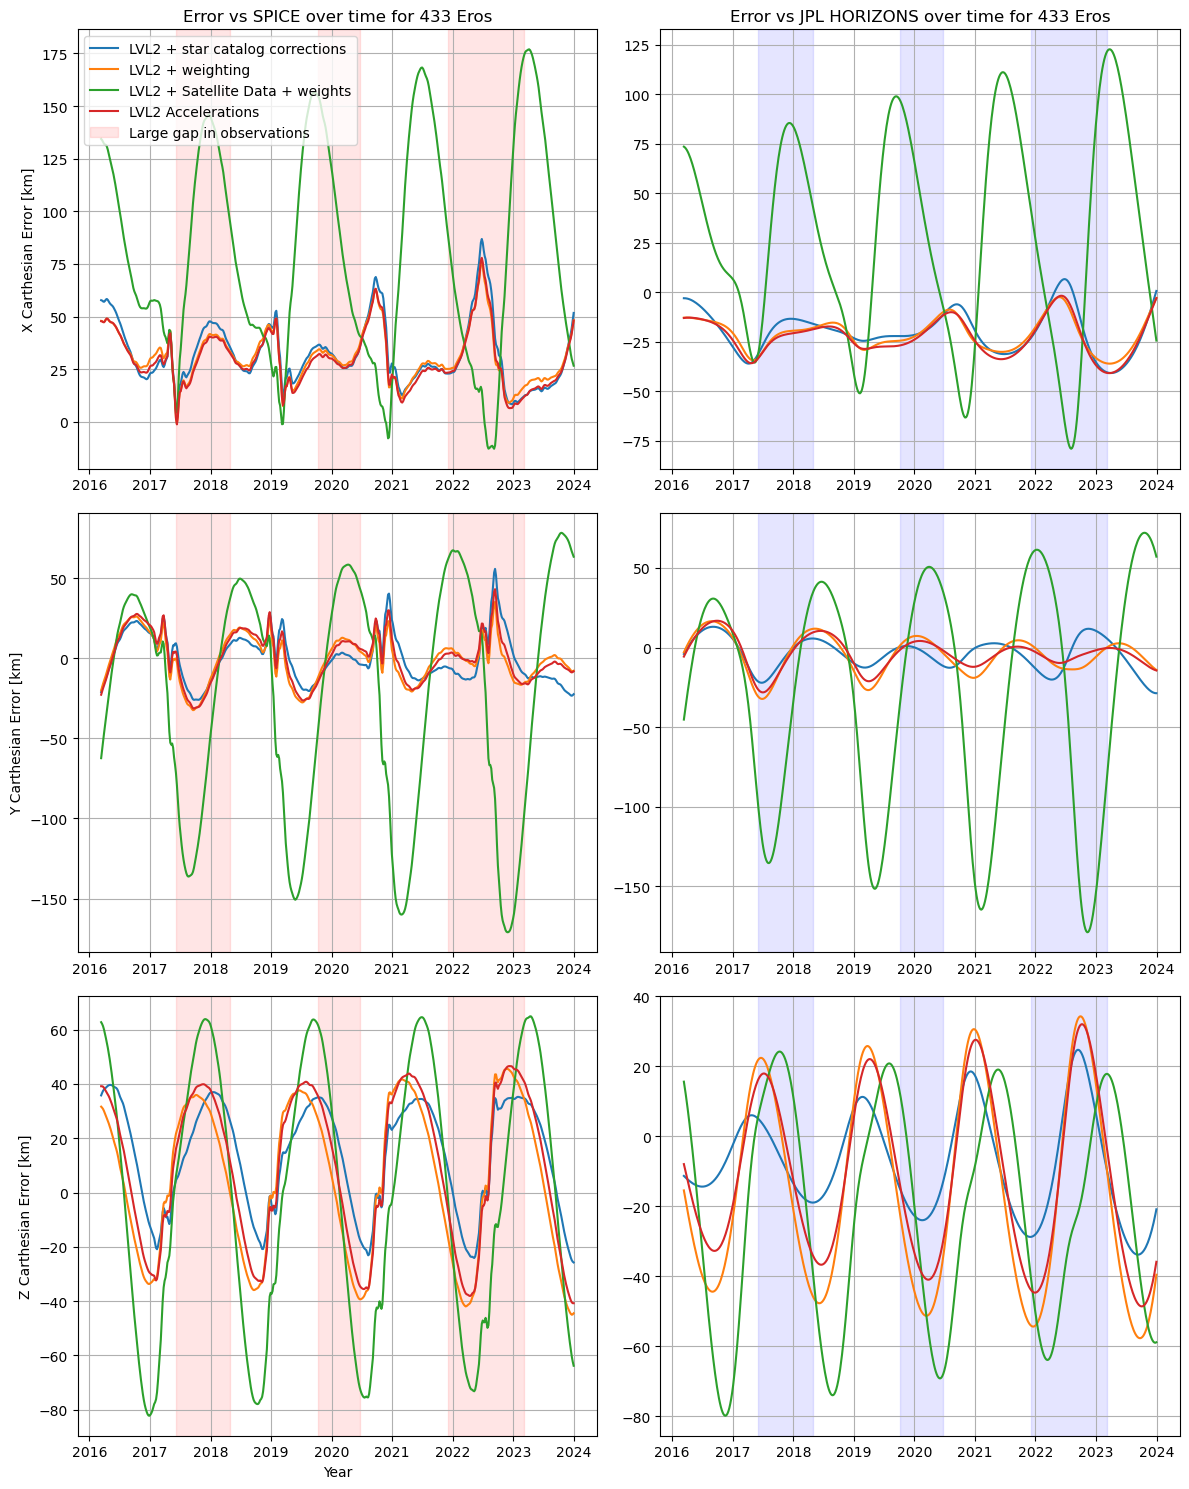

In [ ]:
plot_cartesian(state_estimates_set2, setup_names2, obs_col_set2)

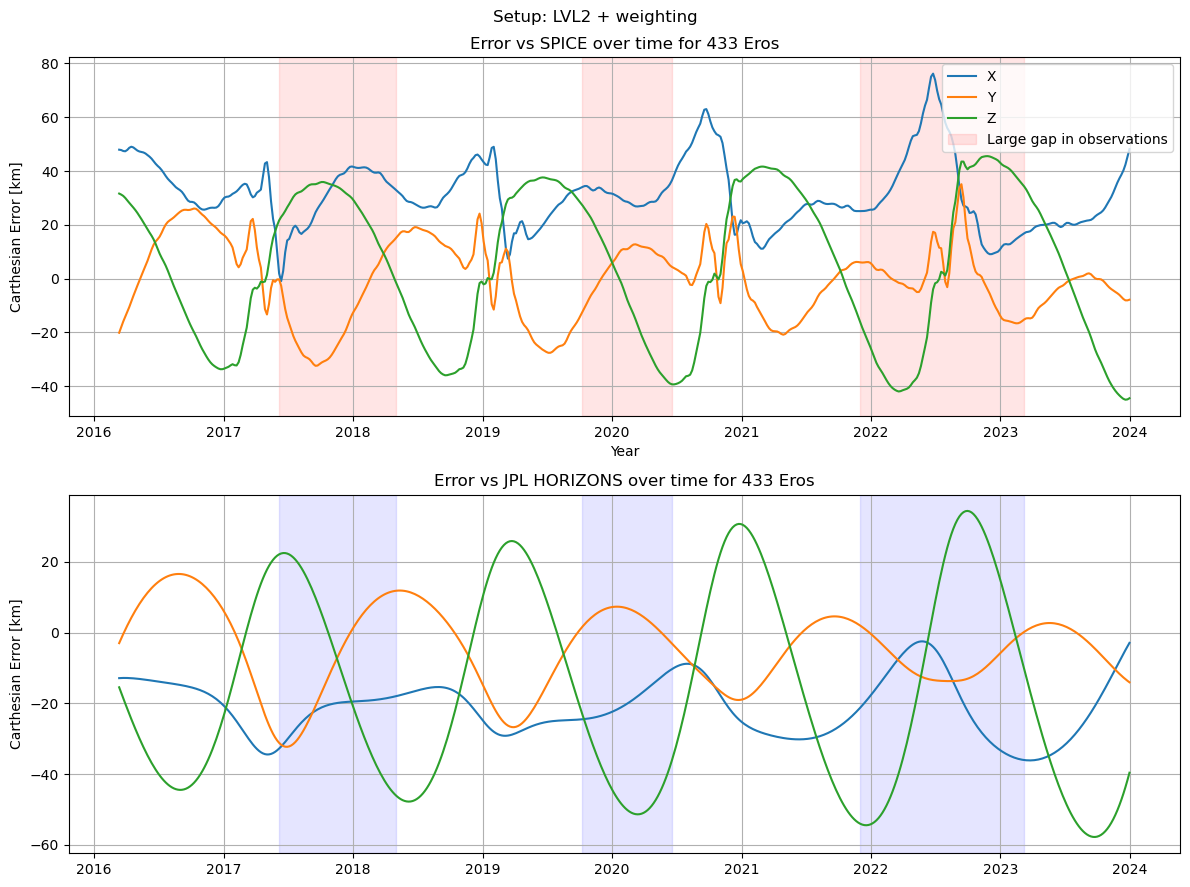

In [ ]:
plot_cartesian_single(state_estimates_set2[1], setup_names2[1], obs_col_set2[1])